In [1]:
### --- Standard libraries ---
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sys

### --- Genomic tools ---
import pysam
from pyfaidx import Fasta  # You'll use this later for sequence extraction

### --- Custom modules ---
#from dna_io import dna_1hot
#import models as mod
#import OccupancyInputCTCF.utils as util
from OccupancyInputCTCF.utils.ml import dna_1hot

### --- File paths ---
bind_sites_filepath = 'files/sonmezer_dataset_CTCT_binding.sites.filtered.mm10.tsv'
bind_freqs_filepath = 'files/binding.frequencies.tsv'
ref_genome_filepath = '/project/fudenber_735/genomes/mm10/mm10.fa' # You'll require the reference genome 


In [2]:
# Load reference genome
ref_genome = pysam.FastaFile(ref_genome_filepath)

# Load binding sites and frequency data
bind_sites = pd.read_table(bind_sites_filepath)
bind_freqs = pd.read_table(bind_freqs_filepath)

In [3]:
# Keep only TFBS clusters that have all 3 biological states, it is a way for validation
site_filter = []
for tfbs in bind_freqs['TFBS_cluster'].unique():
    if len(bind_freqs[bind_freqs['TFBS_cluster'] == tfbs]) == 3:
        site_filter.append(tfbs)

# Filter and rename
bind_sites = bind_sites[bind_sites.rownames.isin(site_filter)]
bind_sites_revised = bind_sites.rename(columns={'rownames': 'TFBS_cluster'})
bind_freqs_dtf = bind_freqs[bind_freqs.TFBS_cluster.isin(site_filter)]

In [4]:
# Pivot table to have states as columns
bind_freqs_pivot = bind_freqs_dtf.pivot_table(
    index='TFBS_cluster',
    columns='biological.state',
    values='Freqs',
    aggfunc='first'
)

# Reset index and reorder columns
bind_freqs_pivot.reset_index(inplace=True)
bind_freqs_pivot = bind_freqs_pivot[['TFBS_cluster', 'Accessible', 'Bound', 'Nucleosome.occupied']]


In [5]:
# Merge with binding site coordinates
binds_sites_freqs = pd.merge(bind_sites_revised, bind_freqs_pivot, on='TFBS_cluster', how='left')

# Save to file
#binds_sites_freqs.to_csv('sites_with_freqs.tsv', sep='\t', index=False)

# Preview result
binds_sites_freqs.head()


,chrom,start,end,width,strand,score,phyloP,rmsk,name,isBound,TF,chipseq.score,TFBS_cluster,Accessible,Bound,Nucleosome.occupied
0,chr1,9541413,9541431,19,-,13.2902,-0.022579,False,CTCF,True,CTCF,401.092987,TFBS_1000,0.503958,0.226913,0.269129
1,chr1,9541469,9541487,19,-,13.2902,0.385316,False,CTCF,True,CTCF,401.092987,TFBS_1001,0.578275,0.271565,0.150160
2,chr1,9545334,9545352,19,-,17.1224,0.913684,False,CTCF,True,CTCF,255.647003,TFBS_1002,0.742331,0.214724,0.042945
3,chr1,11140105,11140123,19,-,13.0579,-0.025105,False,CTCF,True,CTCF,163.445999,TFBS_1005,0.390026,0.052430,0.557545
4,chr1,13500664,13500682,19,-,19.2467,-0.194895,False,CTCF,True,CTCF,299.652008,TFBS_1012,0.500000,0.032338,0.467662


In [6]:
# Optional: select key columns
regions = binds_sites_freqs[['chrom', 'start', 'end', 'Accessible', 'Bound', 'Nucleosome.occupied']]
regions.head()


,chrom,start,end,Accessible,Bound,Nucleosome.occupied
0,chr1,9541413,9541431,0.503958,0.226913,0.269129
1,chr1,9541469,9541487,0.578275,0.271565,0.150160
2,chr1,9545334,9545352,0.742331,0.214724,0.042945
3,chr1,11140105,11140123,0.390026,0.052430,0.557545
4,chr1,13500664,13500682,0.500000,0.032338,0.467662


In [13]:
from pyfaidx import Fasta

# Load genome
fasta = Fasta(ref_genome_filepath)

# Function to get sequence for each row
def get_sequence(row):
    try:
        return fasta[row['chrom']][row['start']:row['end']].seq
    except KeyError:
        return 'N/A'  # Handle any missing chromosomes

# Apply the function to each row
binds_sites_freqs['sequence'] = binds_sites_freqs.apply(get_sequence, axis=1)

# Save to file with sequences included
binds_sites_freqs.to_csv('files/sites_with_freqs_and_seqs.tsv', sep='\t', index=False)
binds_sites_freqs[['chrom','start','end','sequence','Accessible', 'Bound', 'Nucleosome.occupied']].head()


,chrom,start,end,sequence,Accessible,Bound,Nucleosome.occupied
0,chr1,9541413,9541431,AGTGACACCTACTTGCCA,0.503958,0.226913,0.269129
1,chr1,9541469,9541487,AGTGACACCTACTTGCCA,0.578275,0.271565,0.150160
2,chr1,9545334,9545352,GCCGCCCTCTGCCGGTCT,0.742331,0.214724,0.042945
3,chr1,11140105,11140123,GCTGCCACCTTCTGTTTC,0.390026,0.052430,0.557545
4,chr1,13500664,13500682,ACTGCCCTCTGCTGGCTT,0.500000,0.032338,0.467662


In [8]:
# --- One-hot encode sequences ---
input_features = []
for seq in binds_sites_freqs['sequence']:
    one_hot = dna_1hot(seq)  # shape: (length, 4)
    input_features.append(one_hot.astype(int).T)  # shape: (4, length)
input_features = np.stack(input_features)  # shape: (n_samples, 4, length)


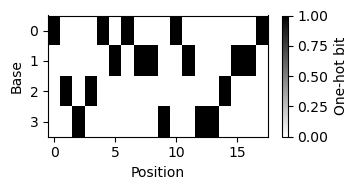

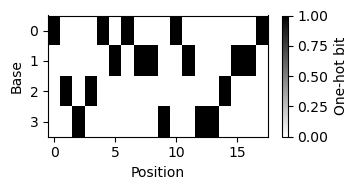

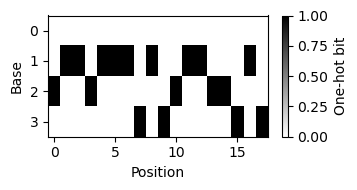

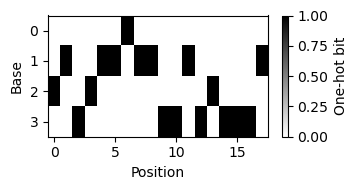

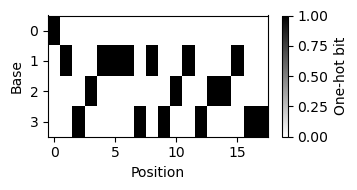

In [12]:
# --- Visualize as grayscale images ---
for i in range(5):  # Change the range as needed
    seq_info = f"{binds_sites_freqs.iloc[i]['chrom']}:{binds_sites_freqs.iloc[i]['start']}-{binds_sites_freqs.iloc[i]['end']}"
    
    #plt.figure(figsize=(10, 1))
    plt.figure(figsize=(len(binds_sites_freqs['sequence'][i]) / 5, 2))  # Dynamic width based on sequence length
    plt.imshow(input_features[i], aspect='auto', interpolation='nearest', cmap='gray_r')
    #plt.title(f"Sequence {i}: {seq_info}")
    plt.xlabel("Position")
    plt.ylabel("Base")
    #plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'T'])
    plt.colorbar(label='One-hot bit')
    plt.tight_layout()
    plt.show()
